# HW1 by Harry Zarcadoolas

In [1]:
# Confirm hw1 venv
!where python

C:\Users\harry\anaconda3\envs\hw1_env\python.exe
C:\Users\harry\anaconda3\python.exe
C:\Program Files\Python312\python.exe
C:\Users\harry\AppData\Local\Microsoft\WindowsApps\python.exe


In [2]:
# The following lines are used to avoid warnings later on by limiting the number of threads my CPU uses
import os
os.environ['OMP_NUM_THREADS'] = '5'

### Imports

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

# Part 1: Data Loading (and Familiarization)
### Load data into dedicated dataframe

In [4]:
# make sure plots are inline
%matplotlib inline

# Define SUMO data file paths for records
file_paths = [
    r"C:\Users\harry\OneDrive - University of Florida\24-fall\CAP4770\assignments\1\HW1\HW1\data\SUMO_8hrs\SUMO_8hrs\record49999.txt",
    r"C:\Users\harry\OneDrive - University of Florida\24-fall\CAP4770\assignments\1\HW1\HW1\data\SUMO_8hrs\SUMO_8hrs\record99999.txt",
    r"C:\Users\harry\OneDrive - University of Florida\24-fall\CAP4770\assignments\1\HW1\HW1\data\SUMO_8hrs\SUMO_8hrs\record149999.txt",
    r"C:\Users\harry\OneDrive - University of Florida\24-fall\CAP4770\assignments\1\HW1\HW1\data\SUMO_8hrs\SUMO_8hrs\record199999.txt",
    r"C:\Users\harry\OneDrive - University of Florida\24-fall\CAP4770\assignments\1\HW1\HW1\data\SUMO_8hrs\SUMO_8hrs\record249999.txt",
    r"C:\Users\harry\OneDrive - University of Florida\24-fall\CAP4770\assignments\1\HW1\HW1\data\SUMO_8hrs\SUMO_8hrs\record299999.txt"
]

# Load the dataset as the main dataframe, beginning with the first file
df = pd.read_csv(file_paths[0], sep='\t',  
                 names=['cur_time', 'vehicle_id', 'x_cord', 'y_cord', 'vehicle_or_pedestrian', 'cluster', 'signal', 'entry', 'maneuver'],  
                 header=None, index_col=False)

# Load and append the remaining files
for file in file_paths[1:]:
    temp_df = pd.read_csv(file, sep='\t',  
                          names=['cur_time', 'vehicle_id', 'x_cord', 'y_cord', 'vehicle_or_pedestrian', 'cluster', 'signal', 'entry', 'maneuver'],  
                          header=None, index_col=False)
    df = pd.concat([df, temp_df], ignore_index=True)

In [5]:
# Display first 5 rows of dataframe
print(df.head())

   cur_time  vehicle_id      x_cord      y_cord  vehicle_or_pedestrian  \
0         1           0  176.478453  253.528941                    0.0   
1         2           0  176.478334  253.844006                    0.0   
2         3           0  176.478207  254.180874                    0.0   
3         4           0  176.478071  254.542244                    0.0   
4         5           0  176.477927  254.923311                    0.0   

   cluster  signal  entry  maneuver  
0        5     0.0      1         1  
1        5     0.0      1         1  
2        5     0.0      1         1  
3        5     0.0      1         1  
4        5     0.0      1         1  


In [6]:
# Display basic info about dataframe
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2193807 entries, 0 to 2193806
Data columns (total 9 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   cur_time               int64  
 1   vehicle_id             int64  
 2   x_cord                 float64
 3   y_cord                 float64
 4   vehicle_or_pedestrian  float64
 5   cluster                int64  
 6   signal                 float64
 7   entry                  int64  
 8   maneuver               int64  
dtypes: float64(4), int64(5)
memory usage: 150.6 MB
None


In [7]:
# Generate descriptive stats for columns
print(df.describe())

           cur_time    vehicle_id        x_cord        y_cord  \
count  2.193807e+06  2.193807e+06  2.193807e+06  2.193807e+06   
mean   1.509746e+05  5.130470e+03  1.712579e+02  2.893580e+02   
std    8.745053e+04  2.972732e+03  1.567538e+01  1.416649e+01   
min    1.000000e+00  0.000000e+00  1.239235e+02  2.495491e+02   
25%    7.361200e+04  2.528000e+03  1.599660e+02  2.808001e+02   
50%    1.523050e+05  5.140000e+03  1.724738e+02  2.887188e+02   
75%    2.288595e+05  7.743000e+03  1.785885e+02  3.000100e+02   
max    2.999990e+05  1.025200e+04  2.151680e+02  3.352537e+02   

       vehicle_or_pedestrian       cluster        signal         entry  \
count              2193807.0  2.193807e+06  2.193807e+06  2.193807e+06   
mean                     0.0  5.064910e+00  1.073869e+00  9.751984e-01   
std                      0.0  3.041659e+00  1.422373e+00  7.855359e-01   
min                      0.0  0.000000e+00  0.000000e+00  0.000000e+00   
25%                      0.0  3.000000e+00  

# Part 2: Spatial Clustering
## Step 1: Initial Clustering using Simple Features

In [8]:
# Group data by vehicle and extract entry, maneuver, and cluster for each
vehicles = df.groupby('vehicle_id').agg({
    'entry': 'first',
    'maneuver': 'first',
    'cluster': 'first'
}).reset_index()

# Use number of entry and maneuver combinations to determine a k-value 
k_value = len(vehicles[['entry', 'maneuver']].drop_duplicates())
print(f"K-value based on entry and maneuver combinations: {k_value}\n")

# Use mode to see which entry and maneuver combinations (9 combinations) map to which ground truth cluster ID -- notice there are ground truth values left out
entry_maneuver_data = vehicles.groupby(['entry', 'maneuver'])['cluster'].agg(pd.Series.mode).reset_index()
print(entry_maneuver_data)

K-value based on entry and maneuver combinations: 9

   entry  maneuver  cluster
0      0         0       10
1      0         1        8
2      0         2        7
3      1         0        6
4      1         1        5
5      1         2        4
6      2         0        3
7      2         1        1
8      2         2        0


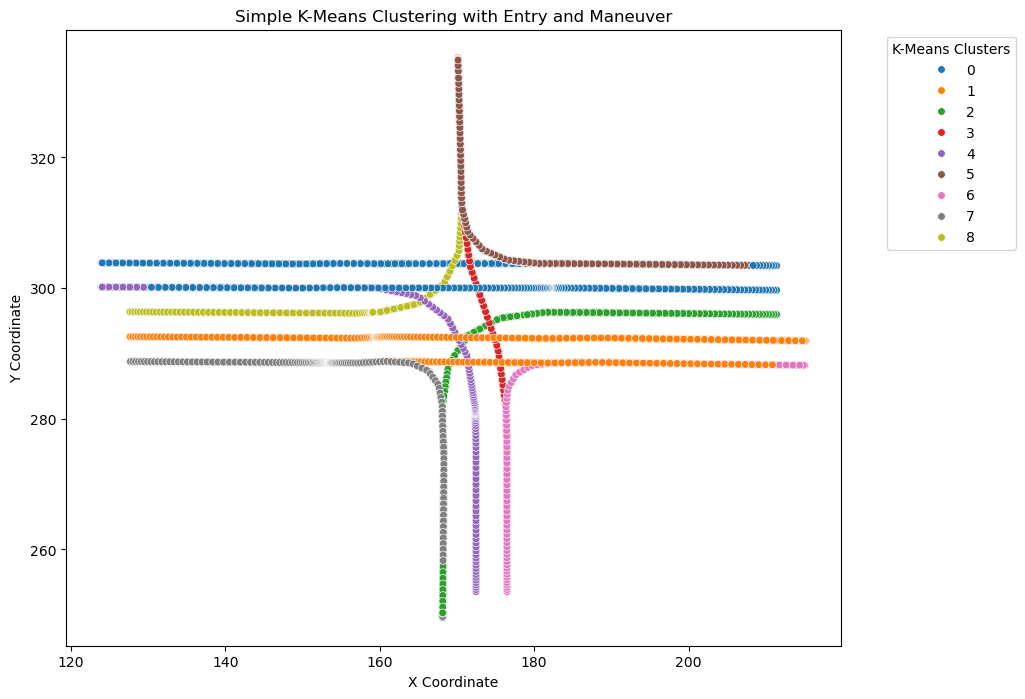

In [9]:
# Apply K-Means clustering to entry and maneuver data
kmeans = KMeans(n_clusters=k_value, random_state=42)
vehicles['kmeans_entry_maneuver'] = kmeans.fit_predict(vehicles[['entry', 'maneuver']])

# Visualize clusters

# Attach new cluster values in a dedicated df with the merged original values for projecting paths with X and Y coordinate in plot
df_clusters_attached = df.merge(vehicles[['vehicle_id', 'kmeans_entry_maneuver']], on='vehicle_id')

# Plot trajectories
plt.figure(figsize=(10, 8))
sns.scatterplot(data=df_clusters_attached, x='x_cord', y='y_cord', hue='kmeans_entry_maneuver', 
                palette='tab10', s=30, legend='full')

# Add titles, labels, legend
plt.title('Simple K-Means Clustering with Entry and Maneuver')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.legend(title='K-Means Clusters', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show plot
plt.show()

## Step 2: Clustering Using Trajectories

In [10]:
# Define 'trajectory_features' subset for each unique vehicle containing start and end x y coordinates and calculated coordinate ranges
trajectory_features = df.groupby('vehicle_id').agg(
    start_x=('x_cord', 'first'),
    start_y=('y_cord', 'first'),
    end_x=('x_cord', 'last'),
    end_y=('y_cord', 'last'),
    x_range=('x_cord', lambda x: x.max() - x.min()),
    y_range=('y_cord', lambda y: y.max() - y.min())
).reset_index()

print(trajectory_features.head()) # Confirm 'trajectory_features' for first few unique vehicles

   vehicle_id     start_x     start_y       end_x       end_y    x_range  \
0           0  176.478453  253.528941  170.145156  335.121454   6.333297   
1           1  127.674940  296.360325  170.152895  334.778463  42.990387   
2           3  211.398181  295.958610  168.155522  250.257184  43.276378   
3           4  211.395864  303.429853  124.449324  303.856226  86.946540   
4           5  176.478453  253.528941  214.743086  288.187634  38.386216   

     y_range  
0  81.592512  
1  38.636176  
2  46.031054  
3   0.426373  
4  35.090668  


In [11]:
# Create 'X' placeholder data from 'trajectory_features' to be clustered
X = trajectory_features[['start_x', 'start_y', 'end_x', 'end_y', 'x_range', 'y_range']]


kmeans = KMeans(n_clusters=11, random_state=42)
trajectory_features['kmeans_cluster_coordinates'] = kmeans.fit_predict(X)

# Do initial internal test of Silhouette Score for validity of cluster before direct comparison with ground truth values
score = silhouette_score(X, trajectory_features['kmeans_cluster_coordinates'])
print(f'Silhouette Score: {score}')

Silhouette Score: 0.9832479034565256


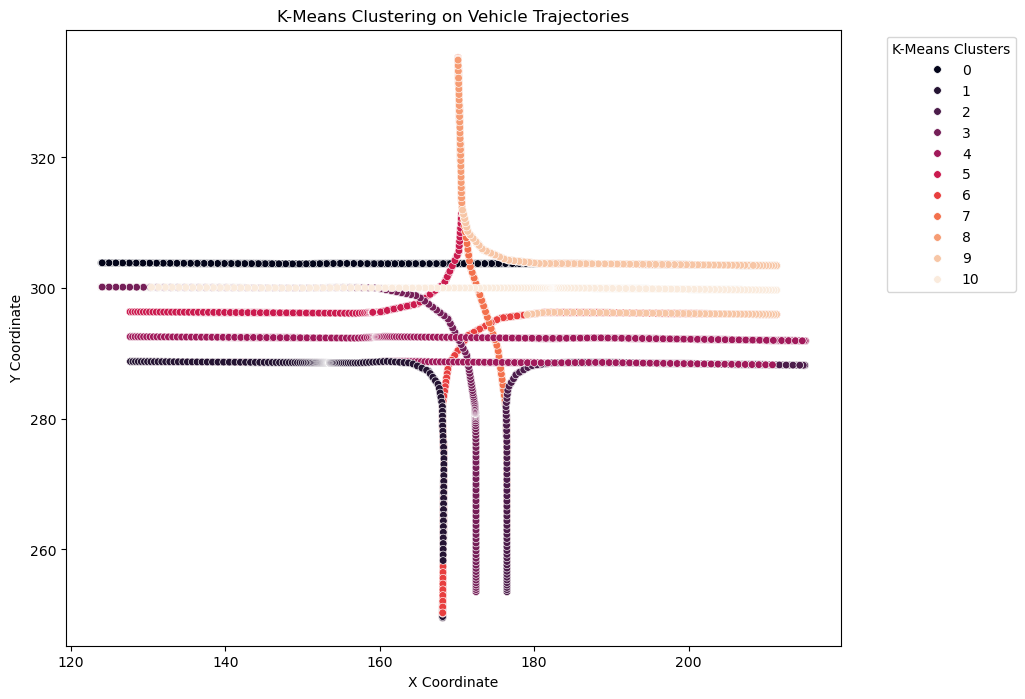

In [12]:
# Merge 'trajectory_features' dataframe (with k-means clusters) back to the full dataframe
df = df.merge(trajectory_features[['vehicle_id', 'kmeans_cluster_coordinates']], on='vehicle_id', how='left')

# Create a scatterplot for the full trajectory data with k-means clusters to determine color
plt.figure(figsize=(10, 8))

sns.scatterplot(x='x_cord', y='y_cord', hue='kmeans_cluster_coordinates', data=df, palette='rocket', s=30, legend='full')

# Visualize Coordinate Clusters based on k-means
plt.title('K-Means Clustering on Vehicle Trajectories')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.legend(title='K-Means Clusters', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [13]:
# Show only unique vehicle IDs by dropping duplicates
unique_vehicles = df[['vehicle_id', 'cluster', 'kmeans_cluster_coordinates']].drop_duplicates(subset='vehicle_id')
print(unique_vehicles.head(10))  # Show the first few unique vehicles for cluster observations to draw conclusions on coordinate based cluster IDs

      vehicle_id  cluster  kmeans_cluster_coordinates
0              0        5                           7
21             1       10                           5
102            3        3                           6
133            4        1                           0
174            5        4                           2
475            6        6                           3
536            7        5                           7
887            8        8                           4
1068           9        6                           3
1738          10        5                           7


### DBSCAN for alternate clustering method of trajectory data

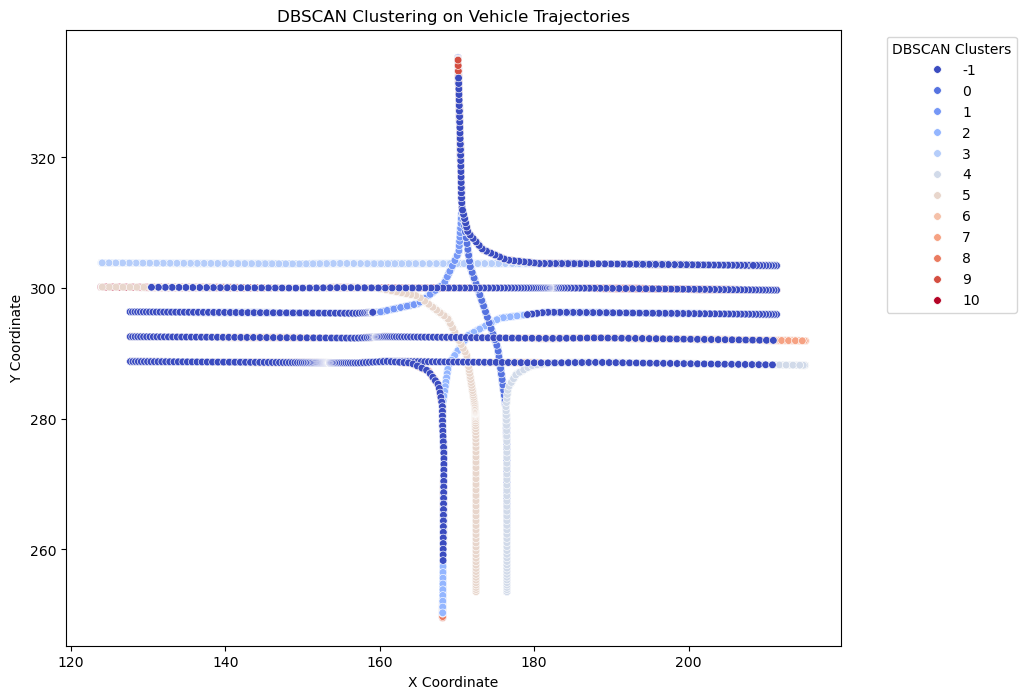

In [14]:
# Apply DBSCAN to the trajectory features
dbscan = DBSCAN(eps=0.5, min_samples=5)  # arbitrary eps=0.5 value
trajectory_features['dbscan_cluster'] = dbscan.fit_predict(X)

# Merge with full data
df = df.merge(trajectory_features[['vehicle_id', 'dbscan_cluster']], on='vehicle_id', how='left')

# Visualize the DBSCAN clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(x='x_cord', y='y_cord', hue='dbscan_cluster', data=df, palette='coolwarm', s=30, legend='full')
plt.title('DBSCAN Clustering on Vehicle Trajectories')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.legend(title='DBSCAN Clusters', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


In [15]:
# Compare coordinate k-means clustering with ground truth cluster values

# Cross-tabulation comparing ground-truth and k-means clusters
comparison_table = pd.crosstab(df['cluster'], df['kmeans_cluster_coordinates'])

# Map each k-means cluster to the most frequent ground truth cluster
cluster_mapping = comparison_table.idxmax(axis=0).to_dict()

# Print the automated cluster mapping for visualization and observation
print("Automated Cluster Mapping (K-Means to Ground-Truth):", cluster_mapping)

# Reassign k-means clusters based on the mapping
df['reassigned_kmeans_cluster'] = df['kmeans_cluster_coordinates'].map(cluster_mapping)

# Calculate the percentage of matching clusters after reassigning
df['matches_reassigned_coordinates'] = df['cluster'] == df['reassigned_kmeans_cluster']
match_rate_reassigned = df['matches_reassigned_coordinates'].mean()
print(f'Adjusted Percentage of Matching Clusters (After Reassignment): {match_rate_reassigned * 100:.2f}%')


Automated Cluster Mapping (K-Means to Ground-Truth): {0: 1, 1: 7, 2: 4, 3: 6, 4: 8, 5: 10, 6: 3, 7: 5, 8: 0, 9: 0, 10: 2}
Adjusted Percentage of Matching Clusters (After Reassignment): 95.42%


In [16]:
# Filter out noise points (-1) for silhouette score calculation
mask = trajectory_features['dbscan_cluster'] != -1  # Exclude noise points
X_filtered = X[mask]  # Keep only non-noise points
labels_filtered = trajectory_features['dbscan_cluster'][mask]  # Filter the labels

# Calculate silhouette score only on the non-noise points
if len(set(labels_filtered)) > 1:  # Since silhouette score require >2 clusters
    sil_score = silhouette_score(X_filtered, labels_filtered)
    print(f'Silhouette Score for DBSCAN (excluding noise): {sil_score}')
else:
    print("Not enough clusters for silhouette score calculation.")


Silhouette Score for DBSCAN (excluding noise): 0.9795757222639497


# Part 3: Temporal Clustering
## Step 1: Feature Creation (Total Time)

In [17]:
# Group by 'vehicle_id' to calculate total time
# 'cur_time' contains the entry and exit times of each vehicle
trajectory_features_temporal = df.groupby('vehicle_id').agg(
    start_time=('cur_time', 'first'),  # Entry time
    end_time=('cur_time', 'last')      # Exit time
).reset_index()

# Calculate the total time taken (exit time - entry time)
trajectory_features_temporal['total_time'] = trajectory_features_temporal['end_time'] - trajectory_features_temporal['start_time']

# View the first few rows to check the results
print(trajectory_features_temporal.head())


   vehicle_id  start_time  end_time  total_time
0           0           1       513         512
1           1          21       315         294
2           3          61       173         112
3           4          71       179         108
4           5          81       516         435


## Step 2: Clustering Using Total Time

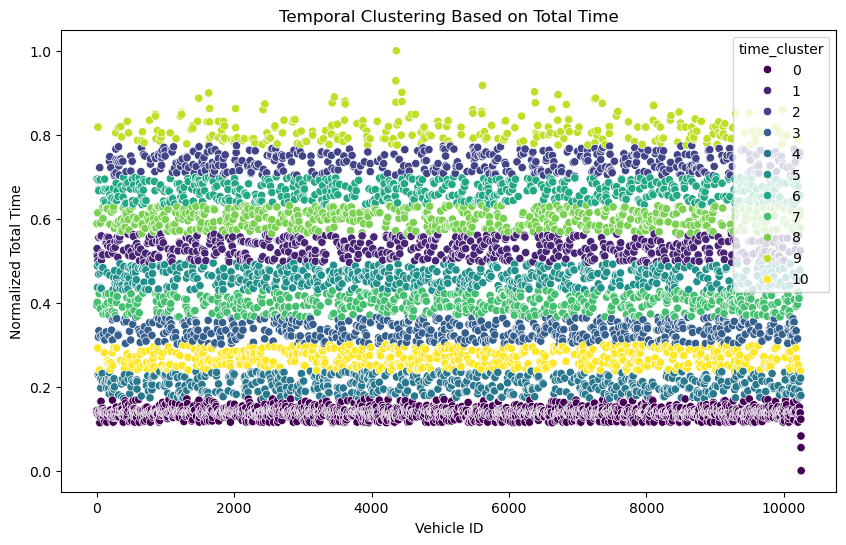

In [18]:
# Normalize the 'total_time'
scaler = MinMaxScaler()
trajectory_features_temporal['total_time_normalized'] = scaler.fit_transform(trajectory_features_temporal[['total_time']])

# Apply k-means clustering on normalized total time
kmeans_temporal = KMeans(n_clusters=11, random_state=42)  # Adjust 'n_clusters' as needed
trajectory_features_temporal['time_cluster'] = kmeans_temporal.fit_predict(trajectory_features_temporal[['total_time_normalized']])

# Visualize the clusters based on temporal data
plt.figure(figsize=(10, 6))
sns.scatterplot(x='vehicle_id', y='total_time_normalized', hue='time_cluster', data=trajectory_features_temporal, palette='viridis', legend='full')
plt.title('Temporal Clustering Based on Total Time')
plt.xlabel('Vehicle ID')
plt.ylabel('Normalized Total Time')
plt.show()

In [19]:
# Merge the temporal clusters back into the main dataframe
df = df.merge(trajectory_features_temporal[['vehicle_id', 'time_cluster']], on='vehicle_id', how='left')

# Cross-tabulation
comparison_table_temporal = pd.crosstab(df['cluster'], df['time_cluster'])

# Map each temporal k-means cluster to the most frequent ground-truth cluster
cluster_mapping_temporal = comparison_table_temporal.idxmax(axis=0).to_dict()

# Print the automated cluster mapping
print("Automated Cluster Mapping (Temporal K-Means to Ground-Truth):", cluster_mapping_temporal)

# Reassign temporal k-means clusters based on the mapping
df['reassigned_time_cluster'] = df['time_cluster'].map(cluster_mapping_temporal)

# Calculate the percentage of matching clusters after reassigning
df['matches_reassigned_temporal'] = df['cluster'] == df['reassigned_time_cluster']
match_rate_reassigned_temporal = df['matches_reassigned_temporal'].mean()
print(f'Adjusted Percentage of Matching Clusters (Temporal Clustering): {match_rate_reassigned_temporal * 100:.2f}%')


Automated Cluster Mapping (Temporal K-Means to Ground-Truth): {0: 3, 1: 4, 2: 5, 3: 7, 4: 3, 5: 0, 6: 6, 7: 3, 8: 10, 9: 6, 10: 7}
Adjusted Percentage of Matching Clusters (Temporal Clustering): 17.54%


In [20]:
print(df.head())

   cur_time  vehicle_id      x_cord      y_cord  vehicle_or_pedestrian  \
0         1           0  176.478453  253.528941                    0.0   
1         2           0  176.478334  253.844006                    0.0   
2         3           0  176.478207  254.180874                    0.0   
3         4           0  176.478071  254.542244                    0.0   
4         5           0  176.477927  254.923311                    0.0   

   cluster  signal  entry  maneuver  kmeans_cluster_coordinates  \
0        5     0.0      1         1                           7   
1        5     0.0      1         1                           7   
2        5     0.0      1         1                           7   
3        5     0.0      1         1                           7   
4        5     0.0      1         1                           7   

   dbscan_cluster  reassigned_kmeans_cluster  matches_reassigned_coordinates  \
0               0                          5                            